In [2]:
import os
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.optim as optim
import torch.nn.functional as F
import cv2
from PIL import Image
from torchsummary import summary
import timm
import gc
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter

import kagglehub
#kagglehub.login()

## Data Analysis

<ipython-input-26-d8e07ff9af49>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


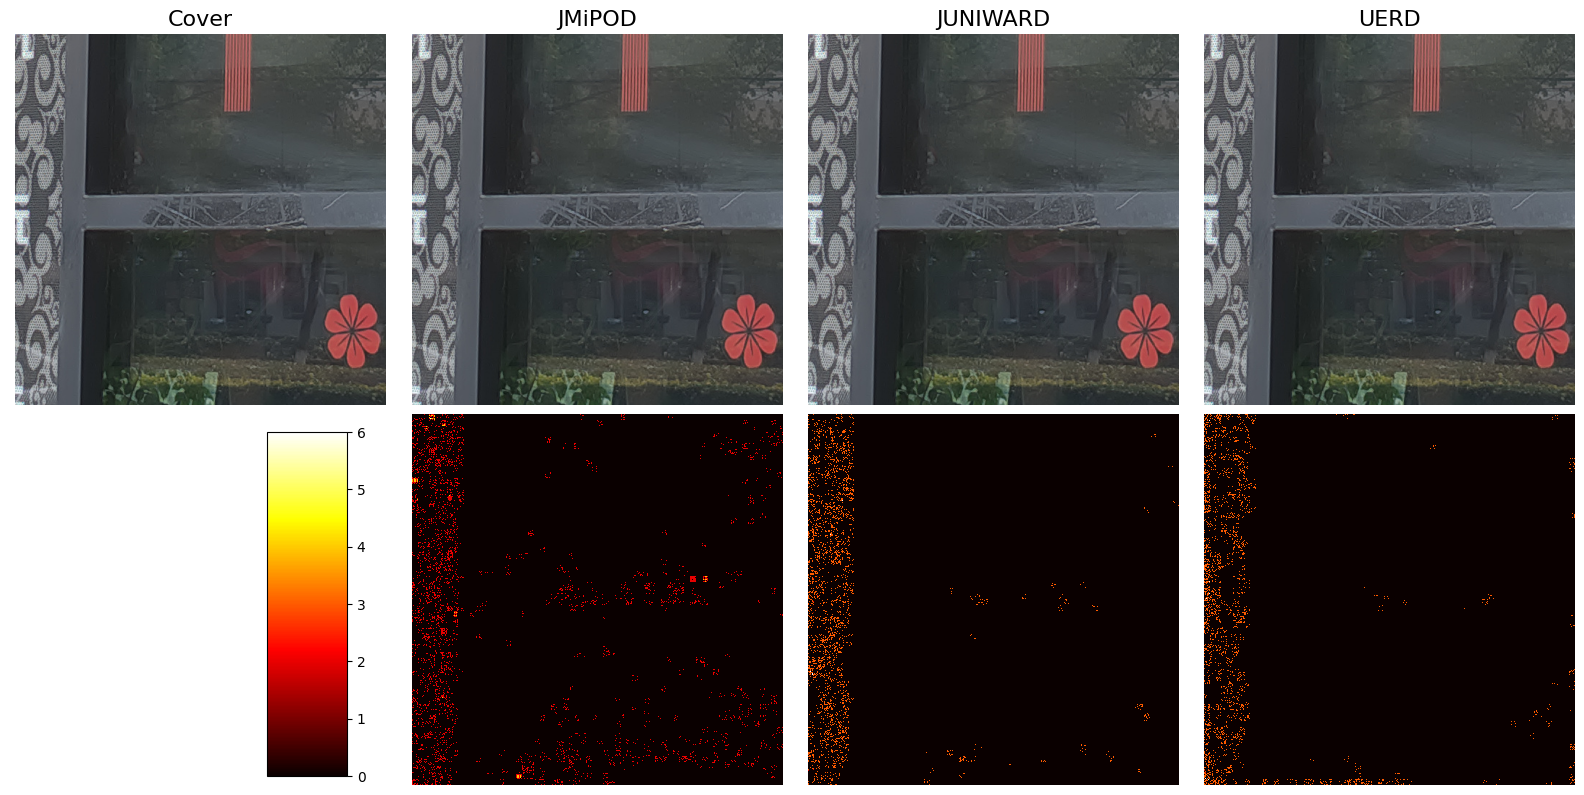

In [26]:
# Define file paths
sample_num = "/00005.jpg"
dataset_path = "/kaggle/input/alaska2-image-steganalysis"
alg_paths = [
    "/Cover",
    "/JMiPOD",
    "/JUNIWARD",
    "/UERD",
]

img_paths = [dataset_path + alg_path + sample_num for alg_path in alg_paths]

# Load images in RGB format
images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in img_paths]

# Compute absolute pixel differences with the cover image
cover_image = images[0]
diff_maps = [np.abs(cover_image.astype(np.int16) - img.astype(np.int16)).sum(axis=2) for img in images[1:]]

# Plot images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

titles = ["Cover", "JMiPOD", "JUNIWARD", "UERD"]

# First row: Cover & Stego images
for i, img in enumerate(images):
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title(titles[i], fontsize=16)  # Increased title size

# Second row: Heatmaps of pixel differences
for i, diff in enumerate(diff_maps):
    im = axes[1, i+1].imshow(diff, cmap='hot', interpolation='nearest')
    axes[1, i+1].axis("off")

# Remove empty first column in the second row
axes[1, 0].axis("off")

# Add colorbar in the empty first position of the second row
cbar_ax = fig.add_axes([0.17, 0.03, 0.05, 0.43])  # Adjust position/size
fig.colorbar(im, cax=cbar_ax, orientation="vertical")

plt.tight_layout()
plt.show()

## Code

In [ ]:
KAGGLE_OUTPUT_DIR = "/kaggle/working/"
WEIGHTS_DIR = KAGGLE_OUTPUT_DIR + "models/"

MODEL_NAMES = {
    1: "efficientnet_binary_soft.pth",
    10: "efficientnet_binary_sig.pth",
    100: "efficientnet_multi.pth",
    1000: "efficientnet_dct.pth",
    101: "efficientnet_high_pass.pth",
    200: "efficientnet_mod.pth",
    201: "efficientnet_mod_high_pass.pth",
    300: "efficientnet_siamese.pth",
    301: "efficientnet_siamese_mod.pth",
    302: "efficientnet_siamese_high_pass.pth",
    303: "efficientnet_siamese_mod_high_pass.pth",
    #3: "efficientnet_binary_hybrid_soft.pth",
    #30: "efficientnet_binary_hybrid_sig.pth",
    #300: "efficientnet_binary_hybrid_multi.pth",
    400: "ccnet.pth",
    500: "lite_ccnet.pth",
    600: "siastegnet.pth",
    10000: "ensemble_jmipod.pth",
    10001: "ensemble_juniward.pth",
    10002: "ensemble_uerd.pth",
    10003: "ensemble.pth",
}

MODEL_PATHS = {key: WEIGHTS_DIR + name for key, name in MODEL_NAMES.items()}




# ==================================================================================  Model Architectures ==================================================================================


# =====================================  EfficientNet =======================================

class LocalSelfAttention(nn.Module):
    def __init__(self, channels, reduction=2, num_heads=4):
        super(LocalSelfAttention, self).__init__()
        self.reduction = reduction
        self.channels = channels
        self.num_heads = num_heads
        self.attn = None  # Initialize later

    def forward(self, x):
        B, C, H, W = x.shape
        reduced_H, reduced_W = max(1, H // self.reduction), max(1, W // self.reduction)

        if self.attn is None:
            embed_dim = (C // self.reduction) * reduced_H * reduced_W
            self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=self.num_heads, batch_first=False).to(x.device)

        # Downsample
        x_downsampled = F.interpolate(x, size=(reduced_H, reduced_W), mode="bilinear", align_corners=False)

        # Flatten and apply self-attention
        x_downsampled = x_downsampled.flatten(2).permute(2, 0, 1)  # (reduced_H * reduced_W, B, C)
        x_attn, _ = self.attn(x_downsampled, x_downsampled, x_downsampled)

        # Reshape back to (B, C, reduced_H, reduced_W)
        x_attn = x_attn.permute(1, 2, 0).reshape(B, C, reduced_H, reduced_W)

        # Upsample to original size
        x_out = F.interpolate(x_attn, size=(H, W), mode="bilinear", align_corners=False)

        return x_out


class CrossAttentionBlock(nn.Module):
    def __init__(self, dim):
        """
        Lightweight Cross-Attention block for feature fusion.
        
        Args:
        - dim (int): Feature channel dimension.
        """
        super(CrossAttentionBlock, self).__init__()
        self.query_proj = nn.Linear(dim, dim)  # Project Image Features (Query)
        self.key_proj = nn.Linear(dim, dim)    # Project SRM Features (Key)
        self.value_proj = nn.Linear(dim, dim)  # Project SRM Features (Value)
        self.softmax = nn.Softmax(dim=-1)      # Normalize attention scores
    
    def forward(self, img_features, srm_features):
        """
        Args:
        - img_features (B, C, H, W): Extracted features from EfficientNet
        - srm_features (B, C, H, W): Extracted SRM-based features
        
        Returns:
        - Cross-attended feature map
        """
        B, C, H, W = img_features.shape
        img_features = img_features.view(B, C, -1).permute(0, 2, 1)  # (B, HW, C)
        srm_C = srm_features.shape[1]  # Get actual channel count
        srm_features = srm_features.view(B, srm_C, -1).permute(0, 2, 1)  # (B, HW, srm_C)

        Q = self.query_proj(img_features.reshape(B * H, C)).view(B, H, -1)
        K = self.key_proj(srm_features)     # (B, HW, C)
        V = self.value_proj(srm_features)   # (B, HW, C)

        attn_scores = self.softmax(torch.bmm(Q, K.transpose(1, 2)) / (C ** 0.5))  # (B, HW, HW)
        fused_features = torch.bmm(attn_scores, V)  # (B, HW, C)
        fused_features = fused_features.permute(0, 2, 1).view(B, C, H, W)  # Reshape back

        return fused_features



class EfficientNetCustom(nn.Module):
    def __init__(self, num_classes, activation="softmax", use_dct=False, use_high_pass_filter=False, use_modification=False, use_siamese=False, pretrained=True):
        """
        Customizable EfficientNet model with optional SRM-based high-pass filtering and structural modifications.
        
        Args:
        - num_classes (int): Number of output classes.
        - activation (str): Activation function, either "softmax" or "sigmoid".
        - use_dct (bool): Whether to enable DCT channels.
        - use_high_pass_filter (bool): Whether to apply SRM high-pass filtering.
        - use_modification (bool): Whether to apply structural modifications.
        - pretrained (bool): Whether to use a pre-trained EfficientNet model.
        """
        super(EfficientNetCustom, self).__init__()
        self.use_dct = use_dct
        self.use_high_pass_filter = use_high_pass_filter
        self.use_modification = use_modification
        self.activation = activation
        self.use_siamese = use_siamese
        
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=pretrained)
        if use_siamese:
            num_features = 675840
            if use_modification:
                num_features = 2662400
        else:
            num_features = self.efficientnet.classifier.in_features

        in_channels = 0

        # Apply SRM High-Pass Filtering if enabled
        if self.use_high_pass_filter:
            self.srm_filter = SRMConv2d(stride=1, padding=2)
            in_channels += 30  # SRM outputs 30 feature maps
        elif self.use_dct:
            in_channels += 4  # Grayscale + 3 DCT channels
        else:
            in_channels += 3  # Normal RGB

        if self.use_modification:
            # Preprocessing conv layers
            self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(6)
            self.conv2 = nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(12)
            self.conv3 = nn.Conv2d(12, 36, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn3 = nn.BatchNorm2d(36)
            if self.use_high_pass_filter:
                in_channels += 36
            else:
                in_channels = 36  # Updated input channels after preprocessing layers


        old_weights = self.efficientnet.conv_stem.weight.data
        
        self.efficientnet.conv_stem = nn.Conv2d(in_channels, self.efficientnet.conv_stem.out_channels, 
                                    kernel_size=self.efficientnet.conv_stem.kernel_size, 
                                    stride=self.efficientnet.conv_stem.stride, 
                                    padding=self.efficientnet.conv_stem.padding, 
                                    bias=False)
        
        # Compute mean of the first 3 channels' weights
        mean_weight = old_weights.mean(dim=1, keepdim=True)  # Average across input channels
        
        # Initialize new weights by repeating the mean weight for all channels
        new_weights = mean_weight.repeat(1, in_channels, 1, 1)
        
        # Copy existing weights for the first 3 channels
        new_weights[:, :3, :, :] = old_weights
        
        # Assign the new weights
        self.efficientnet.conv_stem.weight = nn.Parameter(new_weights)

        if self.use_modification:
            # Remove block 5
            self.efficientnet.blocks[5] = nn.Identity()
            
            # Replace block 6
            #   A 1x1 convolution mapping from the output channels of block 4’s conv_pwl (inside the 3rd sub-block)
            #   to the input channels expected by the conv_head.
            in_channels_block6 = self.efficientnet.blocks[4][2].conv_pwl.out_channels
            out_channels_conv_head = self.efficientnet.conv_head.in_channels
            self.efficientnet.blocks[6] = nn.Sequential(
                nn.Conv2d(in_channels_block6, out_channels_conv_head, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels_conv_head),
                nn.ReLU6(inplace=True)
            )
        
        # Replace classifier
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(num_features, num_classes)
        )

    def forward_features(self, x):
        srm_features = None
        mod_features = None
        
        if self.use_high_pass_filter:
            if x.shape[1] == 3:  # If input has 3 channels (RGB), convert to grayscale
                grayscale_x = 0.2989 * x[:, 0, :, :] + 0.5870 * x[:, 1, :, :] + 0.1140 * x[:, 2, :, :]
                grayscale_x = grayscale_x.unsqueeze(1)  # Add channel dimension (B, 1, H, W)
            else:
                grayscale_x = x  # Already grayscale
    
            srm_features = self.srm_filter(grayscale_x)  # (B, 30, H, W)
    
        if self.use_modification:
            mod_features = F.relu6(self.bn1(self.conv1(x)))  # Keep input RGB (or grayscale if originally 1-channel)
            mod_features = F.relu6(self.bn2(self.conv2(mod_features)))
            mod_features = F.relu6(self.bn3(self.conv3(mod_features)))  # (B, 36, H, W)

    
        if srm_features is not None and mod_features is not None:
            x = torch.cat([srm_features, mod_features], dim=1)  # Concatenate along channel dimension
        elif srm_features is not None:
            x = srm_features
        elif mod_features is not None:
            x = mod_features

        x = self.efficientnet.forward_features(x)
        return x
    
    def forward(self, *args):
        
        if self.use_siamese:
            # Expecting two inputs (e.g., two halves of a steganalysis image)
            feats = torch.stack([self.forward_features(subarea) for subarea in args], dim=0)

            # Compute Euclidean distance between the two feature vectors
            euclidean_distance = F.pairwise_distance(feats[0], feats[1], eps=1e-6, keepdim=True)
            # Concatenate additional statistics
            feats_mean = feats.mean(dim=0)
            feats_var = feats.var(dim=0)
            feats_min, _ = feats.min(dim=0)
            feats_max, _ = feats.max(dim=0)
            final_feat = torch.cat([euclidean_distance, feats_mean, feats_var, feats_min, feats_max], dim=-1)
            final_feat = torch.flatten(final_feat, start_dim=1)
            
            out = self.efficientnet.classifier(final_feat)
            if self.use_modification:
                if isinstance(feats[0], (tuple, list)):
                    feats0 = feats[0][0]  # Extract tensor from tuple/list
                    feats1 = feats[1][0]
                else:
                    feats0 = feats[0]
                    feats1 = feats[1]
                
                #feats0 = torch.mean(feats0, dim=[2, 3])  # Shape: [16, 1280]
                #feats1 = torch.mean(feats1, dim=[2, 3])  # Shape: [16, 1280]
                feats0 = feats[0].reshape(feats[0].shape[0], -1)  # Shape: [16, 1280 * 32 * 16]
                feats1 = feats[1].reshape(feats[1].shape[0], -1)  # Shape: [16, 1280 * 32 * 16]
                return out, feats0, feats1
            return out, feats[0], feats[1]
            
        else:   
            x = args[0]
            x = self.forward_features(x)
            logits = self.efficientnet.classifier(x)
            return logits


class EfficientNetCustomTorch(nn.Module):
    def __init__(self, num_classes, activation="softmax", use_dct=False, use_high_pass_filter=False, pretrained=True):
        """
        Customizable EfficientNet model with optional SRM-based high-pass filtering.
        
        Args:
        - num_classes (int): Number of output classes (1 for sigmoid, 2 for binary softmax, 4 for multi-class softmax).
        - activation (str): Activation function, either "softmax" or "sigmoid".
        - use_dct (bool): Whether to enable DCT channels.
        - use_high_pass_filter (bool): Whether to apply SRM high-pass filtering.
        - pretrained (bool): Whether to use a pre-trained EfficientNet model.
        """
        super(EfficientNetCustomTorch, self).__init__()
        self.use_dct = use_dct
        self.use_high_pass_filter = use_high_pass_filter
        self.activation = activation

        self.efficientnet = models.efficientnet_b0(pretrained=pretrained)
        num_features = self.efficientnet.classifier[1].in_features

        # Apply SRM High-Pass Filtering if enabled
        if self.use_high_pass_filter:
            self.srm_filter = SRMConv2d(stride=1, padding=2)  # Ensures output size matches input size
            in_channels = 30  # SRM outputs 30 feature maps
        elif self.use_dct:
            in_channels = 4  # Grayscale + 3 DCT channels
        else:
            in_channels = 3  # Normal RGB

        # Modify first convolution layer to match input channels
        old_conv = self.efficientnet.features[0][0]
        self.efficientnet.features[0][0] = nn.Conv2d(
            in_channels=in_channels,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=False
        )

        # Replace classifier
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(num_features, num_classes)
        )
    
    def forward(self, x):
        if self.use_high_pass_filter:
            x = self.srm_filter(x)  # Apply SRM filter before feeding into EfficientNet

        logits = self.efficientnet(x)
        
        return logits



# =====================================  EfficientNetBinaryModified =======================================

class EfficientNetBinaryModified(nn.Module):
    def __init__(self, out_dim=2, pretrained=True):
        """
        Modified EfficientNet-B0 for steganalysis.
        
        - Three Conv2D layers are added at the input.
        - The backbone is created with timm, and its conv_stem is modified to accept 36 channels.
        - Block 5 is removed (set to Identity) and Block 6 is replaced with a custom block.
        - The original classifier is removed and replaced by a new fully connected layer.
        """
        super(EfficientNetBinaryModified, self).__init__()
        
        # Preprocessing conv layers:
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12, 36, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3   = nn.BatchNorm2d(36)
        
        # Create EfficientNet-B0 using timm:
        self.enet = timm.create_model('efficientnet_b0', pretrained=pretrained)
        # Modify the conv_stem to accept 36 channels.
        # Original conv_stem has weight shape [out_channels, 3, k, k]. We repeat along channel dim.
        # 3 * 12 = 36.
        self.enet.conv_stem.weight = nn.Parameter(self.enet.conv_stem.weight.repeat(1, 12, 1, 1))
        
        self.dropout = nn.Dropout(0.5)
        
        # Remove block 5:
        self.enet.blocks[5] = nn.Identity()
        # Replace block 6 with:
        #   A 1x1 convolution mapping from the output channels of block 4’s conv_pwl (inside the 3rd sub-block)
        #   to the input channels expected by the conv_head.
        in_channels_block6 = self.enet.blocks[4][2].conv_pwl.out_channels
        out_channels_conv_head = self.enet.conv_head.in_channels
        self.enet.blocks[6] = nn.Sequential(
            nn.Conv2d(in_channels_block6, out_channels_conv_head, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels_conv_head),
            nn.ReLU6(inplace=True)
        )
        # Replace classifier with Identity and add our new FC layer.
        self.myfc = nn.Linear(self.enet.classifier.in_features, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        # Pass through the three initial conv layers with ReLU6 activations:
        x = F.relu6(self.bn1(self.conv1(x)))
        x = F.relu6(self.bn2(self.conv2(x)))
        x = F.relu6(self.bn3(self.conv3(x)))
        # Forward through EfficientNet backbone:
        x = self.enet(x)
        return x

    def forward(self, x):
        x = self.extract(x)
        x = self.dropout(x)
        x = self.myfc(x)
        return x

# =====================================  EfficientNetBinaryHybrid =======================================

class EfficientNetBinaryHybrid(nn.Module):
    def __init__(self, out_dim=2, pretrained=True, activation='softmax'):
        """
        Hybrid EfficientNet model supporting 2-class softmax, sigmoid, and 4-class softmax outputs.
        """
        super(EfficientNetBinaryHybrid, self).__init__()
        
        # Preprocessing conv layers: 1-channel (grayscale) input
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12, 36, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(36)
        
        # Extra lightweight residual block
        self.extra_block = Block2(in_channels=36, out_channels=36)
        
        # EfficientNet-B0 backbone
        self.enet = timm.create_model('efficientnet_b0', pretrained=pretrained)
        self.enet.conv_stem.weight = nn.Parameter(self.enet.conv_stem.weight.repeat(1, 12, 1, 1))
        self.dropout = nn.Dropout(0.5)
        
        # Modify last layers
        self.enet.blocks[5] = nn.Identity()
        in_channels_block6 = self.enet.blocks[4][2].conv_pwl.out_channels
        out_channels_conv_head = self.enet.conv_head.in_channels
        self.enet.blocks[6] = nn.Sequential(
            nn.Conv2d(in_channels_block6, out_channels_conv_head, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels_conv_head),
            nn.ReLU6(inplace=True)
        )
        
        # Fully connected layer
        self.myfc = nn.Linear(self.enet.classifier.in_features, out_dim)
        self.enet.classifier = nn.Identity()
        
        # Activation function choice
        self.activation = activation
        if activation == 'softmax':
            self.final_activation = nn.Softmax(dim=1)
        elif activation == 'sigmoid':
            self.final_activation = nn.Sigmoid()
        else:
            raise ValueError("Unsupported activation function. Choose 'softmax' or 'sigmoid'.")

    def extract(self, x):
        x = F.relu6(self.bn1(self.conv1(x)))
        x = F.relu6(self.bn2(self.conv2(x)))
        x = F.relu6(self.bn3(self.conv3(x)))
        x = self.extra_block(x)
        x = self.enet(x)
        return x

    def forward(self, x):
        x = self.extract(x)
        x = self.dropout(x)
        x = self.myfc(x)
        return self.final_activation(x)


# =====================================  StegoMobileNet =======================================

class StegoMobileNet(nn.Module):
    def __init__(self, pretrained=True):
        super(StegoMobileNet, self).__init__()
        self.backbone = models.mobilenet_v3_small(pretrained=pretrained)
        
        # Modify first layer to accept 512x512 images if necessary
        self.backbone.features[0][0] = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False)
        
        # Replace classifier head with a binary classifier
        in_features = self.backbone.classifier[0].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)  # 2 logits for binary classification (Cover vs. Stego)
        )

    def forward(self, x):
        return self.backbone(x)




# =====================================  CCNet =======================================

#########################################
# SE Block (Squeeze-and-Excitation Block)
#########################################

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        """
        Args:
            channels (int): Number of channels of the input feature map.
            reduction (int): Reduction ratio for the intermediate channel dimension.
        """
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Output: (B, C, 1, 1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze: global average pooling
        y = self.global_avg_pool(x).view(b, c)
        # Excitation: FC -> ReLU -> FC -> Sigmoid
        y = self.fc(y).view(b, c, 1, 1)
        # Scale: channel-wise multiplication
        return x * y

#########################################
# Block 1: Conv + BN + ReLU
#########################################

class Block1(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        """
        A basic convolutional block.
        """
        super(Block1, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

#########################################
# Block 2: Residual block with channel attention
#########################################

class Block2(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Block 2 consists of:
          - An identity branch using Block1.
          - A residual branch: Conv -> BN -> ReLU -> Conv -> BN -> SEBlock.
          - The two branches are added and passed through a ReLU.
        """
        super(Block2, self).__init__()
        # Identity branch
        self.identity = Block1(in_channels, out_channels)
        # Residual branch
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)  # Channel Attention Module (SE block)
        
    def forward(self, x):
        identity = self.identity(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out = identity + out  # Residual addition
        return self.relu(out)

#########################################
# Block 3: Downsampling block with dual-path residual connection
#########################################

class Block3(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Block 3 has two paths:
          - Branch 1: 3×3 conv (stride 2) -> BN -> ReLU -> 3×3 conv -> SEBlock.
          - Branch 2 (projection): 1×1 conv (stride 2) -> BN.
          - The outputs of both branches are added and passed through a ReLU.
        """
        super(Block3, self).__init__()
        # Branch 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.se = SEBlock(out_channels)
        # Branch 2 (projection shortcut)
        self.proj_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
        self.proj_bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        branch1 = self.relu(self.bn1(self.conv1(x)))
        branch1 = self.conv2(branch1)
        branch1 = self.se(branch1)
        branch2 = self.proj_bn(self.proj_conv(x))
        out = branch1 + branch2
        return self.relu(out)

#########################################
# Block 4: Feature integration with global average pooling
#########################################

class Block4(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Block 4 consists of:
          - A Block1 (Conv+BN+ReLU).
          - A Conv layer.
          - BN.
          - Global Average Pooling.
        """
        super(Block4, self).__init__()
        self.block1 = Block1(in_channels, out_channels)
        self.conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Reduces HxW to 1x1
     
    def forward(self, x):
        x = self.block1(x)
        x = self.relu(self.bn(self.conv(x)))
        x = self.global_avg_pool(x)
        return x  # Output shape: (B, out_channels, 1, 1)

#########################################
# Major Modules
#########################################

# Noise Extraction Module
class NoiseExtractionModule(nn.Module):
    def __init__(self):
        super(NoiseExtractionModule, self).__init__()
        # Two layers of Block1: L1 and L2.
        # For 512x512 input, the output remains 512x512 since these blocks do not downsample.
        self.L1 = Block1(in_channels=1, out_channels=64)   # Input is grayscale (1 channel)
        self.L2 = Block1(in_channels=64, out_channels=16)
        # Five layers of Block2: L3, L4, L5, L6, L7 (all operate at 16 channels).
        # Output will remain at 512x512 spatial size.
        self.L3 = Block2(in_channels=16, out_channels=16)
        self.L4 = Block2(in_channels=16, out_channels=16)
        self.L5 = Block2(in_channels=16, out_channels=16)
        self.L6 = Block2(in_channels=16, out_channels=16)
        self.L7 = Block2(in_channels=16, out_channels=16)
    
    def forward(self, x):
        x = self.L1(x)
        x = self.L2(x)
        x = self.L3(x)
        x = self.L4(x)
        x = self.L5(x)
        x = self.L6(x)
        x = self.L7(x)
        return x  # Expected output: (B, 16, 512, 512)

# Noise Analysis Module
class NoiseAnalysisModule(nn.Module):
    def __init__(self):
        super(NoiseAnalysisModule, self).__init__()
        # Four layers of Block3:
        # For 512x512 input from the extraction module, each Block3 downsamples by 2:
        # L8: 512 -> 256, L9: 256 -> 128, L10: 128 -> 64, L11: 64 -> 32.
        # Final output: (B, 256, 32, 32)
        self.L8 = Block3(in_channels=16, out_channels=16)
        self.L9 = Block3(in_channels=16, out_channels=64)
        self.L10 = Block3(in_channels=64, out_channels=128)
        self.L11 = Block3(in_channels=128, out_channels=256)
    
    def forward(self, x):
        x = self.L8(x)  # 512 -> 256
        x = self.L9(x)  # 256 -> 128, channels: 64
        x = self.L10(x) # 128 -> 64, channels: 128
        x = self.L11(x) # 64 -> 32, channels: 256
        return x  # Expected output: (B, 256, 32, 32)

# Judging Module
class JudgingModule(nn.Module):
    def __init__(self):
        super(JudgingModule, self).__init__()
        # Block4: L12. With input from Noise Analysis (B, 256, 32, 32),
        # global pooling will reduce the spatial size to (B, 512, 1, 1).
        self.L12 = Block4(in_channels=256, out_channels=512)
        self.fc = nn.Linear(512, 4)  # 4 classes
     
    def forward(self, x):
        x = self.L12(x)           # x shape: (B, 512, 1, 1)
        x = x.view(x.size(0), -1) # Flatten to (B, 512)
        x = self.fc(x)
        return x

#########################################
# CCNet: Full Architecture for 512x512 Input
#########################################

class CCNet(nn.Module):
    def __init__(self):
        super(CCNet, self).__init__()
        self.noise_extraction = NoiseExtractionModule()
        self.noise_analysis = NoiseAnalysisModule()
        self.judging = JudgingModule()
    
    def forward(self, x):
        # x is now expected to be a grayscale image of shape (B, 1, 512, 512)
        x = self.noise_extraction(x)
        x = self.noise_analysis(x)
        x = self.judging(x)
        return x


# =====================================  LiteCCNet =======================================

#########################################
# Block 4: Lite Judging Block with Global Average Pooling
#########################################

class LiteBlock4(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        A simplified feature integration block.
        Uses a basic conv block followed by global average pooling.
        """
        super(LiteBlock4, self).__init__()
        self.conv = Block1(in_channels, out_channels)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.relu = nn.ReLU(inplace=True)
     
    def forward(self, x):
        x = self.conv(x)
        x = self.global_avg_pool(x)
        return self.relu(x)  # Output: (B, out_channels, 1, 1)

#########################################
# Lite Noise Extraction Module
#########################################

class LiteNoiseExtractionModule(nn.Module):
    def __init__(self):
        super(LiteNoiseExtractionModule, self).__init__()
        # Use one Block1 and one Block2 instead of many:
        self.L1 = Block1(in_channels=1, out_channels=16)   # Input: grayscale, output 16 channels.
        self.L2 = Block2(in_channels=16, out_channels=16)    # Preserve spatial dimensions.
    
    def forward(self, x):
        x = self.L1(x)
        x = self.L2(x)
        return x  # Expected output: (B, 16, 512, 512)

#########################################
# Lite Noise Analysis Module
#########################################

class LiteNoiseAnalysisModule(nn.Module):
    def __init__(self):
        super(LiteNoiseAnalysisModule, self).__init__()
        # Use two Block3 layers to downsample:
        # First Block3: 512 → 256, from 16 channels to 32.
        # Second Block3: 256 → 128, from 32 channels to 64.
        self.L3 = Block3(in_channels=16, out_channels=32)
        self.L4 = Block3(in_channels=32, out_channels=64)
    
    def forward(self, x):
        x = self.L3(x)  # Spatial: 512 -> 256, channels: 32.
        x = self.L4(x)  # Spatial: 256 -> 128, channels: 64.
        return x  # Expected output: (B, 64, 128, 128)

#########################################
# Lite Judging Module
#########################################

class LiteJudgingModule(nn.Module):
    def __init__(self):
        super(LiteJudgingModule, self).__init__()
        # Use a LiteBlock4 to integrate features and pool:
        self.L5 = LiteBlock4(in_channels=64, out_channels=128)
        self.fc = nn.Linear(128, 2)
    
    def forward(self, x):
        x = self.L5(x)   # Output shape: (B, 128, 1, 1)
        x = x.view(x.size(0), -1)  # Flatten to (B, 128)
        x = self.fc(x)
        return x

#########################################
# Lite CCNet: Full Architecture for 512x512 Input
#########################################

class LiteCCNet(nn.Module):
    def __init__(self):
        super(LiteCCNet, self).__init__()
        self.noise_extraction = LiteNoiseExtractionModule()
        self.noise_analysis = LiteNoiseAnalysisModule()
        self.judging = LiteJudgingModule()
    
    def forward(self, x):
        # x is expected to be a grayscale image of shape (B, 1, 512, 512)
        x = self.noise_extraction(x)
        x = self.noise_analysis(x)
        x = self.judging(x)
        return x

# =====================================  SiaStegNet (FROM OFFICIAL IMPLEMENTATION AT https://github.com/SiaStg/SiaStegNet/tree/master) =======================================

# Utility convolution functions
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

# ---------------------------
# SRMConv2d: A fixed high-pass filter layer for steganalysis
# ---------------------------
SRM_npy = np.load("/kaggle/input/srm_kernels.npy/pytorch/default/1/SRM_Kernels.npy")
class SRMConv2d(nn.Module):
    def __init__(self, stride=1, padding=0):
        super(SRMConv2d, self).__init__()
        self.in_channels = 1
        self.out_channels = 30
        self.kernel_size = (5, 5)
        self.stride = (stride, stride) if isinstance(stride, int) else stride
        self.padding = (padding, padding) if isinstance(padding, int) else padding
        self.dilation = (1, 1)
        self.groups = 1
        self.weight = Parameter(torch.Tensor(30, 1, 5, 5), requires_grad=True)
        self.bias = Parameter(torch.Tensor(30), requires_grad=True)
        self.reset_parameters()
    def reset_parameters(self):
        # Copy the fixed SRM kernels from file
        self.weight.data.copy_(torch.tensor(SRM_npy, dtype=torch.float32))
        self.bias.data.zero_()
    def forward(self, input):
        return F.conv2d(input, self.weight, self.bias, self.stride, self.padding,
                        self.dilation, self.groups)


# ---------------------------
# BlockA and BlockB as defined in the original code
# ---------------------------
class BlockA(nn.Module):
    def __init__(self, in_planes, out_planes, norm_layer=nn.BatchNorm2d):
        super(BlockA, self).__init__()
        self.conv1 = conv3x3(in_planes, out_planes)
        self.bn1 = norm_layer(out_planes)
        self.conv2 = conv3x3(out_planes, out_planes)
        self.bn2 = norm_layer(out_planes)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class BlockB(nn.Module):
    def __init__(self, in_planes, out_planes, norm_layer=nn.BatchNorm2d):
        super(BlockB, self).__init__()
        self.conv1 = conv3x3(in_planes, out_planes, stride=2)
        self.bn1 = norm_layer(out_planes)
        self.conv2 = conv3x3(out_planes, out_planes)
        self.bn2 = norm_layer(out_planes)
        self.shortcut_conv = conv1x1(in_planes, out_planes, stride=2)
        self.shortcut_bn = norm_layer(out_planes)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        identity = self.shortcut_bn(self.shortcut_conv(identity))
        out += identity
        return self.relu(out)

# ---------------------------
# KeNet: SiaStegNet as a Siamese Network
# ---------------------------
class SiaStegNet(nn.Module):
    def __init__(self, out_dim=2, norm_layer=None, zero_init_residual=True, p=0.5):
        super(SiaStegNet, self).__init__()
        self.zero_init_residual = zero_init_residual
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.srm = SRMConv2d(1, 0)  # Operates on grayscale input
        self.bn1 = norm_layer(30)

        self.A1 = BlockA(30, 30, norm_layer=norm_layer)
        self.A2 = BlockA(30, 30, norm_layer=norm_layer)
        self.AA = BlockA(30, 30, norm_layer=norm_layer)

        self.B3 = BlockB(30, 64, norm_layer=norm_layer)
        self.A3 = BlockA(64, 64, norm_layer=norm_layer)

        self.B4 = BlockB(64, 128, norm_layer=norm_layer)
        self.A4 = BlockA(128, 128, norm_layer=norm_layer)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * 4 + 1, out_dim)  # Combining multiple statistics
        self.dropout = nn.Dropout(p=p)
        self.relu = nn.ReLU(inplace=True)

        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, std=0.01)
        if self.zero_init_residual:
            for m in self.modules():
                if isinstance(m, (BlockA, BlockB)):
                    nn.init.constant_(m.bn2.weight, 0)

    def extract_feat(self, x):
        x = x.float()
        out = self.srm(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.A1(out)
        out = self.A2(out)
        out = self.AA(out)
        out = self.B3(out)
        out = self.A3(out)
        out = self.B4(out)
        out = self.A4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), out.size(1))
        return out

    def forward(self, *args):
        # Enforce that two input tensors are provided.
        if len(args) != 2:
            raise ValueError(f"SiaStegNet expects exactly 2 input tensors, but got {len(args)}.")
    
        # Expecting two inputs (e.g., two halves of a steganalysis image)
        feats = torch.stack([self.extract_feat(subarea) for subarea in args], dim=0)
        # Compute Euclidean distance between the two feature vectors
        euclidean_distance = F.pairwise_distance(feats[0], feats[1], eps=1e-6, keepdim=True)
        # Concatenate additional statistics
        feats_mean = feats.mean(dim=0)
        feats_var = feats.var(dim=0)
        feats_min, _ = feats.min(dim=0)
        feats_max, _ = feats.max(dim=0)
        final_feat = torch.cat([euclidean_distance, feats_mean, feats_var, feats_min, feats_max], dim=-1)
        out = self.dropout(final_feat)
        out = self.fc(out)
        return out, feats[0], feats[1]


# ===================================== Model Utility Functions =======================================

def load_architecture(mode, device):
    if mode == 1:
        model = EfficientNetCustomTorch(num_classes=2, activation="softmax", use_dct=False, pretrained=True)  # Softmax over 2 values (cover/stego)
    elif mode == 10:
        model = EfficientNetCustomTorch(num_classes=1, activation="sigmoid", use_dct=False, pretrained=True)  # Sigmoid for binary classification
    elif mode == 100:
        model = EfficientNetCustomTorch(num_classes=4, activation="softmax", use_dct=False, pretrained=True)  # Softmax over 4 values (cover + 3 stego types)
    elif mode == 1000:
        model = EfficientNetCustomTorch(num_classes=2, activation="softmax", use_dct=True, pretrained=True)  # Softmax over 4 values (cover + 3 stego types)
    elif mode == 101:
        model = EfficientNetCustomTorch(num_classes=4, activation="softmax", use_high_pass_filter=True, pretrained=True)
    elif mode == 200:
        model = EfficientNetCustom(num_classes=4, activation="softmax", use_high_pass_filter=False, pretrained=True, use_modification=True)
    elif mode == 201:
        model = EfficientNetCustom(num_classes=4, activation="softmax", use_high_pass_filter=True, pretrained=True, use_modification=True)
    elif mode == 300:
        model = EfficientNetCustom(num_classes=4, activation="softmax", use_high_pass_filter=False, pretrained=True, use_modification=False, use_siamese=True)
    elif mode == 301:
        model = EfficientNetCustom(num_classes=4, activation="softmax", use_high_pass_filter=False, pretrained=True, use_modification=True, use_siamese=True)
    elif mode == 302:
        model = EfficientNetCustom(num_classes=4, activation="softmax", use_high_pass_filter=True, pretrained=True, use_modification=False, use_siamese=True)
    elif mode == 303:
        model = EfficientNetCustom(num_classes=4, activation="softmax", use_high_pass_filter=True, pretrained=True, use_modification=True, use_siamese=True)
    elif mode == 2:
        model = EfficientNetBinaryModified(pretrained=True)
    elif mode == 3:
        model = EfficientNetBinaryHybrid(out_dim=2, activation='softmax')
    elif mode == 30:
        model = EfficientNetBinaryHybrid(out_dim=1, activation='sigmoid')
    elif mode == 400:
        model = CCNet()
    elif mode == 500:
        model = LiteCCNet()
    elif mode == 600:
        model = SiaStegNet(out_dim=4, norm_layer=None, zero_init_residual=True, p=0.2)
    elif mode in [10000, 10001, 10002]:
        model = StegoMobileNet()
    model = model.to(device)
    return model



def save_model(model, optimizer, epoch, path='efficientnet_binary.pth'):
    """Save model state, optimizer state, and epoch."""
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(state, path)
    print(f"Model saved to {path}")


def save_model_kaggle(model, optimizer, epoch, local_model_dir, model_slug, variation_slug, version_notes, filename='checkpoint.pth'):
    """
    Saves a model checkpoint locally and uploads it to Kaggle using kagglehub.
    
    Args:
        model (torch.nn.Module): The model to save.
        optimizer (torch.optim.Optimizer): The optimizer.
        epoch (int): The current epoch number.
        local_model_dir (str): Local directory where the checkpoint file will be saved.
        model_slug (str): Kaggle model slug (e.g. 'my_model').
        variation_slug (str): Variation slug (e.g. 'default').
        version_notes (str): Version notes for the Kaggle model upload.
        filename (str): The filename for the checkpoint file.
    """
    # Ensure local model directory exists.
    os.makedirs(local_model_dir, exist_ok=True)
    checkpoint_path = os.path.join(local_model_dir, filename)
    
    # Save the checkpoint locally.
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved locally at {checkpoint_path}")
    
    # Log in to Kaggle Hub.
    kagglehub.login()
    
    # Construct the handle for the Kaggle model.
    handle = f"amauriciogonzalez/{model_slug}/pyTorch/{variation_slug}"
    
    # Upload the model files from the local_model_dir.
    kagglehub.model_upload(
        handle=handle,
        local_model_dir=local_model_dir,
        version_notes=version_notes
    )
    print(f"Model uploaded to Kaggle with handle: {handle}")




def load_model(model, optimizer, path='efficientnet_binary.pth', device='cuda'):
    """Load model state, optimizer state, and epoch."""
    print(path)
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Model loaded from {path}, starting from epoch {start_epoch}")
    return model, optimizer, start_epoch


# ================================================================================== Datasets ==================================================================================

class SteganographyDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path, label, algorithm = self.image_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label, algorithm

# ===================================== Dataset Utility Functions =======================================

def get_valid_images(data_dir):
    """Retrieve all valid image names that exist in the dataset."""
    cover_images = set(os.listdir(os.path.join(data_dir, "Cover")))
    stego_images = {
        "JMiPOD": set(os.listdir(os.path.join(data_dir, "JMiPOD"))),
        "JUNIWARD": set(os.listdir(os.path.join(data_dir, "JUNIWARD"))),
        "UERD": set(os.listdir(os.path.join(data_dir, "UERD")))
    }
    return cover_images, stego_images
    

def load_dataset(data_dir, train=True, n=0, cover_dist_percentage=0.5, batch_size=32, transform=None, mode=0, target_alg=None, group_by_base_image=False):
    cover_images, stego_images = get_valid_images(data_dir)
    
    image_list = []
    start_idx, end_idx = (1, 65000) if train else (65000, 75000)
    
    valid_filenames = [f"{i:05d}.jpg" for i in range(start_idx, end_idx)]
    valid_filenames = [f for f in valid_filenames if f in cover_images or any(f in stego_images[alg] for alg in stego_images)]

    if group_by_base_image:
        if target_alg:
            # Ensure we select `n/2` unique images and get both Cover + target algorithm images
            unique_count = n // 2 if n > 0 else len(valid_filenames)
            selected_base_images = random.sample(valid_filenames, min(unique_count, len(valid_filenames)))

            for filename in selected_base_images:
                if filename in cover_images:
                    image_list.append((os.path.join(data_dir, "Cover", filename), 0, "Cover"))
                if filename in stego_images.get(target_alg, set()):
                    image_list.append((os.path.join(data_dir, target_alg, filename), 1, target_alg))
        else:
            # Ensure we select `n/4` unique images and get all variations for each
            unique_count = n // 4 if n > 0 else len(valid_filenames)
            selected_base_images = random.sample(valid_filenames, min(unique_count, len(valid_filenames)))
    
            for filename in selected_base_images:
                if filename in cover_images:
                    image_list.append((os.path.join(data_dir, "Cover", filename), 0, "Cover"))
    
                for algo, label in zip(["JMiPOD", "JUNIWARD", "UERD"], [1, 2, 3] if (100 <= mode < 1000) else [1, 1, 1]):
                    if filename in stego_images[algo]:  
                        image_list.append((os.path.join(data_dir, algo, filename), label, algo))
    
    else:
        # Original method: Randomly select images while balancing classes
        num_cover = int(len(valid_filenames) * cover_dist_percentage)
        num_stego = len(valid_filenames) - num_cover

        selected_cover = random.sample(valid_filenames, num_cover)
        
        for filename in selected_cover:
            image_list.append((os.path.join(data_dir, "Cover", filename), 0, "Cover"))

        if target_alg:  
            valid_stego = [f for f in valid_filenames if f in stego_images.get(target_alg, set())]
            selected_stego = random.sample(valid_stego, min(num_stego, len(valid_stego)))
            
            for filename in selected_stego:
                image_list.append((os.path.join(data_dir, target_alg, filename), 1, target_alg))
        else:
            num_per_stego_type = num_stego // 3

            for algo, label in zip(["JMiPOD", "JUNIWARD", "UERD"], [1, 2, 3] if (100 <= mode < 1000) else [1, 1, 1]):
                valid_stego = [f for f in valid_filenames if f in stego_images[algo]]
                selected_stego = random.sample(valid_stego, min(num_per_stego_type, len(valid_stego)))
                for filename in selected_stego:
                    image_list.append((os.path.join(data_dir, algo, filename), label, algo))
    
    if n > 0 and not group_by_base_image:
        image_list = random.sample(image_list, min(n, len(image_list)))

    dataset = SteganographyDataset(image_list, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader



def preprocess_sia(images):
    """
    Splits each image in the batch along the width.
    Expects images to be of shape (B, C, H, W) with C==1.
    Returns a list with two tensors: left and right halves.
    """
    B, C, H, W = images.shape
    # Make width even
    if W % 2 != 0:
        images = images[..., :W-1]
        W = W - 1
    half = W // 2
    left = images[..., :half]
    right = images[..., half:]
    return [left, right]


# ============================ DCT Transformation ============================

def rgb_to_dct(image):
    """
    Convert an RGB image to full-resolution DCT coefficients.
    
    Args:
    - image (PIL.Image): Input RGB image.

    Returns:
    - torch.Tensor: DCT representation of the image (C, H, W).
    """
    image = np.array(image)  # Convert PIL image to numpy array (H, W, C)
    h, w, c = image.shape
    dct_channels = []

    for i in range(c):  # Apply DCT per channel
        channel_dct = cv2.dct(image[:, :, i].astype(np.float32))  # Full DCT transform
        dct_channels.append(channel_dct)  # Keep the full DCT

    dct_tensor = np.stack(dct_channels, axis=0)  # Shape: (C, H, W)
    
    return torch.tensor(dct_tensor, dtype=torch.float32)

# ============================ Custom Transformations ============================

class DCTTransform:
    def __init__(self, num_dct_channels=3, normalize_dct=True):
        self.num_dct_channels = num_dct_channels
        self.normalize_dct = normalize_dct

    def __call__(self, img):
        dct_tensor = rgb_to_dct(img)  # Shape: (C, H, W)

        if self.normalize_dct:
            mean = dct_tensor.mean(dim=(1, 2), keepdim=True)
            std = dct_tensor.std(dim=(1, 2), keepdim=True) + 1e-6  # Avoid division by zero
            dct_tensor = (dct_tensor - mean) / std  # Normalize per-channel

        return dct_tensor


class GrayDCTTransform:
    def __init__(self, num_dct_channels=3):
        self.num_dct_channels = num_dct_channels
        self.grayscale_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale
        ])
        self.dct_transform = DCTTransform(num_dct_channels=self.num_dct_channels)

    def __call__(self, img):
        img_gray = self.grayscale_transform(img)  # Shape: (1, H, W)
        img_dct = self.dct_transform(img)  # Shape: (C, H, W)
        

        return torch.cat([img_gray, img_dct], dim=0)  # Shape: (4, H, W)


class RGBToYCbCr:
    def __call__(self, img):
        return img.convert("YCbCr")  # Convert from RGB to YCbCr

# ============================ Data Normalization & Transforms ============================

def get_transforms(mode):
    """
    Returns the appropriate transformations based on the mode.
    
    Args:
    - mode (int): Mode defining whether to use RGB, Grayscale, or DCT.

    Returns:
    - train_transform, val_transform
    - input_size (tuple): Input dimensions for model initialization.
    """
    if mode >= 1000 and mode < 10000:  # Use Grayscale + DCT
        num_dct_channels = 3  # You can adjust this

        train_transform = transforms.Compose([
            GrayDCTTransform(num_dct_channels=num_dct_channels),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip()
        ])
        
        val_transform = GrayDCTTransform(num_dct_channels=num_dct_channels)

        input_size = (1 + num_dct_channels, 512, 512)  # (C, H, W)
        
    elif mode in [3, 30, 101, 400, 600]:  # Use Grayscale
        train_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
        ])
        
        val_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
        ])
        
        input_size = (1, 512, 512)  # (C, H, W) for grayscale

    elif mode in [10000, 10001, 10002, 10003]:
        train_transform = transforms.Compose([
            RGBToYCbCr(),  # Convert to YCbCr
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])  # Adjust based on dataset statistics
        ])
        
        val_transform = transforms.Compose([
            RGBToYCbCr(),  # Convert to YCbCr
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])
        ])

        input_size = (3, 512, 512)  

    else:  # Use RGB
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
        ])
        
        val_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
        ])
        
        input_size = (3, 512, 512)  # (C, H, W) for RGB
    
    return train_transform, val_transform, input_size





# ================================================================================== Training ==================================================================================


# ===================================== Loss Functions =======================================

# Assuming cover 0 stego 1
class ContrastiveLoss(nn.Module):

    def __init__(self, margin=1.25):  # margin=2
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        label = label.to(torch.float32)
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive


class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction="none")
        pt = torch.exp(-ce_loss)  # Probability of correct class
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:  # Apply class weighting if given
            alpha_weight = self.alpha.gather(0, targets.view(-1))
            focal_loss *= alpha_weight

        return focal_loss.mean()



def alaska_weighted_auc(y_true, y_valid):
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights =        [       2,   1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_valid, pos_label=1)
    
    # size of subsets
    areas = np.array(tpr_thresholds[1:]) - np.array(tpr_thresholds[:-1])
    
    # The total area is normalized by the sum of weights such that the final weighted AUC is between 0 and 1.
    normalization = np.dot(areas, weights)
    
    competition_metric = 0
    for idx, weight in enumerate(weights):
        y_min = tpr_thresholds[idx]
        y_max = tpr_thresholds[idx + 1]
        mask = (y_min < tpr) & (tpr < y_max)

        x_padding = np.linspace(fpr[mask][-1], 1, 100)

        x = np.concatenate([fpr[mask], x_padding])
        y = np.concatenate([tpr[mask], [y_max] * len(x_padding)])
        y = y - y_min # normalize such that curve starts at y=0
        score = metrics.auc(x, y)
        submetric = score * weight
        best_subscore = (y_max - y_min) * weight
        competition_metric += submetric
        
    return competition_metric / normalization



# ===================================== Train Function =======================================

def train_model(mode, model, train_loader, val_loader, optimizer, device, epochs=5, starting_epoch=0, lr=0.001, stego_threshold=0.5, save=True, alpha=0.1, patience=3):

    # For classification
    if mode < 10 or mode in [10000, 10001, 10002] or (1000 <= mode < 10000):
        criterion = nn.CrossEntropyLoss()
    elif 10 <= mode < 100:
        #criterion = nn.BCELoss()
        #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.0]).to(device)) 
        # Define class weights if needed (optional)
        #class_weights = torch.tensor([1.0, 1.5], device="cuda")  # Adjust if imbalance exists

        # Instantiate Focal Loss
        criterion = FocalLoss(alpha=None, gamma=2)
    else:
        criterion = nn.CrossEntropyLoss()

    if mode in [300, 301, 302, 303, 600]:
        contrastive_criterion = ContrastiveLoss(margin=1.25)
    
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1,
                                  threshold=0.0001, threshold_mode='abs', cooldown=0, min_lr=1e-8, eps=1e-08)

    
    
    model.to(device)
    model.train()

    print(f'{("="*20)}  TRAINING {("="*20)}')
    print(f'Number of training samples: {len(train_loader.dataset)}')
    # Count occurrences of each class in the training dataset
    all_labels = []
    for _, labels, _ in train_loader:
        all_labels.extend(labels.cpu().numpy())  # Convert to list and store
    
    class_counts = Counter(all_labels)
    
    print("Class distribution in training dataset:")
    for cls, count in sorted(class_counts.items()):
        print(f"Class {cls}: {count} samples")

    best_val_loss = float('inf')  # Track the best validation loss
    total_start_time = time.time()  # Start total training timer
    epochs += starting_epoch
    epochs_since_improvement = 0  # Counter for early stopping
    
    for epoch in range(starting_epoch, epochs):
        epoch_start_time = time.time()  # Start epoch timer
        
        running_loss = 0.0
        correct, total = 0, 0
        train_bin_correct, train_bin_total = 0, 0  # For binary accuracy
        all_labels, all_outputs = [], []

        for images, labels, _ in train_loader:
            

            # For modes 1,2,3: use the images as they are.
            # For mode 4 (SiaStegNet), preprocess images to get two halves.
            if mode in [300, 301, 302, 303, 600]:
                # images is expected to be of shape (N, C, H, W) with C==1 (grayscale)
                inputs = preprocess_sia(images)
                # Convert labels to LongTensor with shape (N,)
                labels = labels.to(device).long().view(-1)
                outputs, feats0, feats1 = model(*[inp.to(device) for inp in inputs])
                # Compute classification loss plus weighted contrastive loss.
                loss_cls = criterion(outputs, labels)
                #print(f"feats0 shape: {feats0.shape}")
                #print(f"feats1 shape: {feats1.shape}")
                #print(f"labels shape: {labels.shape}")
                loss_contrast = contrastive_criterion(feats0, feats1, labels)
                loss = loss_cls + alpha * loss_contrast
            else:
                images, labels = images.to(device), labels.float().to(device)
                labels = labels.clone().detach().to(device).long().view(-1)
                outputs = model(images) # outputs shape: (B, 2)
                if 10 <= mode < 100:
                    #outputs = outputs.squeeze()  # Ensure outputs are correctly shaped for BCE loss
                    labels = labels.float().unsqueeze(1)
                loss = criterion(outputs, labels)

            
            optimizer.zero_grad()
            loss.backward()

            if mode in [300, 301, 302, 303, 600]:  # Only clip when using the Siamese architecture
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            running_loss += loss.item()
            if 10 <= mode < 100:
                predicted = (outputs > 0.5).float()
            else:
                predicted = outputs.argmax(dim=1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)


            # Compute binary accuracy (binning stego classes)
            bin_labels = (labels > 0).long()  # Convert 1, 2, 3 into "stego" (1)
            bin_preds = (predicted > 0).long()
            train_bin_correct += (bin_preds == bin_labels).sum().item()
            train_bin_total += labels.size(0)
  
        
        train_acc = (correct / total) * 100
        train_bin_acc = (train_bin_correct / train_bin_total) * 100  # Binary accuracy
            
        val_metrics = evaluate_model(mode, model, val_loader, criterion, device, stego_threshold=stego_threshold, validation=True)

        avg_loss = running_loss / len(train_loader)
        scheduler.step(avg_loss)  # Update scheduler based on avg loss
        
        epoch_time = (time.time() - epoch_start_time) / 60  # Convert to minutes
        print(f"""Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Train Acc: {train_acc:.2f}% - Train Bin Acc: {train_bin_acc:.2f}%
        Val Loss: {val_metrics['avg_loss']:.4f} - Val Acc: {val_metrics['accuracy']:.2f}% - Val Bin Acc: {val_metrics['bin_accuracy']:.2f}% - Time: {epoch_time:.2f} min
        Cover Acc: {val_metrics['accuracy_cover']:.2f}% | JMiPOD Acc: {val_metrics['accuracy_jmipod']:.2f}% | 
        JUNIWARD Acc: {val_metrics['accuracy_juniward']:.2f}% | UERD Acc: {val_metrics['accuracy_uerd']:.2f}%
        Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f} | F1 Score: {val_metrics['f1']:.4f}
        """)

        
        # Save the model if it has the best validation loss so far
        if save and val_metrics['avg_loss'] < best_val_loss:
            best_val_loss = val_metrics['avg_loss']
            save_path = MODEL_PATHS[mode]
            
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            save_model(model, optimizer, epoch+1, path=save_path)

            """
            LOCAL_MODEL_DIR = WEIGHTS_DIR        # Local directory to store model files
            MODEL_SLUG = 'ccn'              # Your Kaggle model slug
            VARIATION_SLUG = 'default'           # Your variation slug
            VERSION_NOTES = ''    # Version notes for the model upload
            
            save_model_kaggle(model, optimizer, epoch+1, 
                              local_model_dir=LOCAL_MODEL_DIR,
                              model_slug=MODEL_SLUG,
                              variation_slug=VARIATION_SLUG,
                              version_notes=VERSION_NOTES)
            """
            
            epochs_since_improvement = 0
            print(f"*** New best model saved at epoch {epoch+1} with validation loss: {best_val_loss:.2f}")
        else:
            epochs_since_improvement += 1
            print(f"No improvement for {epochs_since_improvement} epoch(s).")

        # Early stopping check:
        if epochs_since_improvement >= patience:
            print(f"Early stopping triggered after {epochs_since_improvement} epochs with no improvement.")
            break

    total_time = (time.time() - total_start_time) / 60  # Convert to minutes
    print(f"\nTotal Training Time: {total_time:.2f} min")


# ================================================================================== Evaluation ==================================================================================

def evaluate_model(mode, model, val_loader, criterion, device, stego_threshold=0.5, validation=True):
    model.eval()
    total, correct = 0, 0
    total_loss = 0.0
    bin_correct, bin_total = 0, 0  # Binary accuracy counters

    # Track stats for individual classes
    correct_cover = 0
    total_cover = 0
    correct_jmipod = 0
    total_jmipod = 0
    correct_juniward = 0
    total_juniward = 0
    correct_uerd = 0
    total_uerd = 0
    
    y_true = []
    y_pred = []


    if not validation: 
        print(("="*20) + " EVALUATION" + ("="*20))
        print(f'Number of testing samples: {len(val_loader.dataset)}')


    total_start_time = time.time()
        

    with torch.no_grad():
        for images, labels, algorithms in val_loader:
            images, labels = images.to(device), labels.float().to(device)
            labels = labels.clone().detach().to(device).long().view(-1)

            if mode in [300, 301, 302, 303, 600]:
                inputs = preprocess_sia(images)
                labels = labels.to(device).long().view(-1)
                outputs, _, _ = model(*[inp.to(device) for inp in inputs])
            else:
                images, labels = images.to(device), labels.to(device).long().view(-1)
                outputs = model(images)

            if mode < 10:
                predictions = torch.argmax(outputs, dim=1)
            elif 10 <= mode < 100:
                predictions = (outputs > 0.5).float()
                #outputs = outputs.squeeze()
                labels = labels.float().unsqueeze(1)
            else:
                predictions = torch.argmax(outputs, dim=1)

            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Store predictions and labels for precision/recall calculations
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

            # Track per-algorithm accuracy
            for i in range(len(labels)):
                algo = algorithms[i]  # Algorithm name
                if algo == "Cover":
                    total_cover += 1
                    correct_cover += (predictions[i] == labels[i]).item()
                elif algo == "JMiPOD":
                    total_jmipod += 1
                    correct_jmipod += (predictions[i] == labels[i]).item()
                elif algo == "JUNIWARD":
                    total_juniward += 1
                    correct_juniward += (predictions[i] == labels[i]).item()
                elif algo == "UERD":
                    total_uerd += 1
                    correct_uerd += (predictions[i] == labels[i]).item()

            # Compute binary accuracy (binning stego classes)
            bin_labels = (labels > 0).long()
            bin_preds = (predictions > 0).long()
            bin_correct += (bin_preds == bin_labels).sum().item()
            bin_total += labels.size(0)

    # Compute accuracies
    accuracy = (correct / total) * 100
    accuracy_cover = (correct_cover / total_cover) * 100 if total_cover > 0 else 0
    accuracy_jmipod = (correct_jmipod / total_jmipod) * 100 if total_jmipod > 0 else 0
    accuracy_juniward = (correct_juniward / total_juniward) * 100 if total_juniward > 0 else 0
    accuracy_uerd = (correct_uerd / total_uerd) * 100 if total_uerd > 0 else 0
    bin_accuracy = (bin_correct / bin_total) * 100 if bin_total > 0 else 0

    if 100 <= mode < 1000: # Multiclass classification
        average_type = 'macro'
    else: # Binary classification
        average_type = 'binary'  
    
    precision = precision_score(y_true, y_pred, average=average_type, zero_division=0)
    recall = recall_score(y_true, y_pred, average=average_type, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average_type, zero_division=0)

    total_time = (time.time() - total_start_time) / 60  # Convert to minutes

    if not validation:
        print(f"Evaluation completed in {total_time:.2f} minutes.")
        print(f"Overall Accuracy: {accuracy:.2f}%")
        print(f"Accuracy (Cover): {accuracy_cover:.2f}%")
        print(f"Accuracy (JMiPOD): {accuracy_jmipod:.2f}%")
        print(f"Accuracy (JUNIWARD): {accuracy_juniward:.2f}%")
        print(f"Accuracy (UERD): {accuracy_uerd:.2f}%")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    return {
        "accuracy": accuracy,
        "accuracy_cover": accuracy_cover,
        "accuracy_jmipod": accuracy_jmipod,
        "accuracy_juniward": accuracy_juniward,
        "accuracy_uerd": accuracy_uerd,
        "bin_accuracy": bin_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "avg_loss": total_loss / len(val_loader),
    }





# ================================================================================== Main ==================================================================================

def main(FLAGS):
    DATA_DIR = "/kaggle/input/alaska2-image-steganalysis"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    

    train_transform, val_transform, input_size = get_transforms(FLAGS.mode)
    
    
    train_loader = load_dataset(DATA_DIR,
                                train=True,
                                n=FLAGS.train_n,
                                cover_dist_percentage=FLAGS.cover_dist_percentage,
                                batch_size=FLAGS.batch_size,
                                transform=train_transform,
                                mode=FLAGS.mode,
                                target_alg=FLAGS.target_alg,
                                group_by_base_image=FLAGS.group_by_base_image)
    val_loader = load_dataset(DATA_DIR,
                              train=False,
                              n=FLAGS.evaluate_n,
                              cover_dist_percentage=FLAGS.cover_dist_percentage,
                              batch_size=FLAGS.batch_size,
                              transform=val_transform,
                              mode=FLAGS.mode,
                              target_alg=FLAGS.target_alg,
                              group_by_base_image=FLAGS.group_by_base_image)

    # Initialize model
    model = load_architecture(FLAGS.mode, device)
    #print(model)

    #summary(model, input_size)

    optimizer = optim.AdamW(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-4)  # AdamW with weight decay
    
    if FLAGS.load:
        model, optimizer, starting_epoch = load_model(model, optimizer, path=MODEL_PATHS[FLAGS.mode], device=device)
    else:
        starting_epoch = 0

    if FLAGS.train:
        train_model(FLAGS.mode, model, train_loader, val_loader, optimizer, device, epochs=Flags.epochs, lr=FLAGS.learning_rate, stego_threshold=0.5, save=FLAGS.save, starting_epoch=starting_epoch, alpha=0.1, patience=10)

    if FLAGS.evaluate:
        criterion = nn.CrossEntropyLoss()
        val_metrics = evaluate_model(FLAGS.mode, model, val_loader, criterion, device, stego_threshold=0.5, validation=False)
        print(f"""Val Loss: {val_metrics['avg_loss']:.4f} - Val Acc: {val_metrics['accuracy']:.2f}% - Val Bin Acc: {val_metrics['bin_accuracy']:.2f}%
        Cover Acc: {val_metrics['accuracy_cover']:.2f}% | JMiPOD Acc: {val_metrics['accuracy_jmipod']:.2f}% | 
        JUNIWARD Acc: {val_metrics['accuracy_juniward']:.2f}% | UERD Acc: {val_metrics['accuracy_uerd']:.2f}%
        Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f} | F1 Score: {val_metrics['f1']:.4f}
        """)


    

In [4]:
if __name__ == "__main__":
    class Flags:
        mode = 1
        load = False
        save = True
        train = True
        train_n = 10000
        epochs = 20
        learning_rate = 0.0001
        evaluate = False
        evaluate_n = 1000
        batch_size = 32
        cover_dist_percentage = 0.5
        target_alg = None
        group_by_base_image = False


    FLAGS = Flags
    
    main(FLAGS)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 185MB/s]


====================  TRAINING ====================
Number of training samples: 10000
Class distribution in training dataset:
Class 0: 4996 samples
Class 1: 5004 samples
Epoch 1/20 - Loss: 0.6943 - Train Acc: 52.02%
        Val Loss: 0.6753 - Val Acc: 54.70% - Time: 4.27 min
        Cover Acc: 56.03% | JMiPOD Acc: 46.10% | 
        JUNIWARD Acc: 49.41% | UERD Acc: 64.20%
        Precision: 0.5340 | Recall: 0.5329 | F1 Score: 0.5335
        
Model saved to /kaggle/working/models/efficientnet_binary_soft.pth
*** New best model saved at epoch 1 with validation loss: 0.68
Epoch 2/20 - Loss: 0.7059 - Train Acc: 55.10%
        Val Loss: 0.6671 - Val Acc: 56.10% - Time: 4.02 min
        Cover Acc: 97.28% | JMiPOD Acc: 2.60% | 
        JUNIWARD Acc: 1.18% | UERD Acc: 33.95%
        Precision: 0.8133 | Recall: 0.1255 | F1 Score: 0.2175
        
Model saved to /kaggle/working/models/efficientnet_binary_soft.pth
*** New best model saved at epoch 2 with validation loss: 0.67
Epoch 3/20 - Loss: 0.6

In [15]:
if __name__ == "__main__":
    class Flags:
        mode = 10
        load = False
        save = True
        train = True
        train_n = 10000
        epochs = 10
        learning_rate = 0.0001
        evaluate = False
        evaluate_n = 1000
        batch_size = 16
        cover_dist_percentage = 0.5
        target_alg = None
        group_by_base_image = False


    gc.collect()


    FLAGS = Flags
    
    main(FLAGS)

====================  TRAINING ====================
Number of training samples: 10000
Class distribution in training dataset:
Class 0: 5025 samples
Class 1: 4975 samples
Epoch 1/10 - Loss: 0.0000 - Train Acc: 50.20%
        Val Loss: 0.0000 - Val Acc: 52.60% - Time: 4.36 min
        Cover Acc: 100.00% | JMiPOD Acc: 0.00% | 
        JUNIWARD Acc: 0.00% | UERD Acc: 0.00%
        Precision: 0.0000 | Recall: 0.0000 | F1 Score: 0.0000
        
Model saved to /kaggle/working/models/efficientnet_binary_sig.pth
*** New best model saved at epoch 1 with validation loss: 0.00
Epoch 2/10 - Loss: 0.0000 - Train Acc: 50.25%
        Val Loss: 0.0000 - Val Acc: 52.60% - Time: 4.10 min
        Cover Acc: 100.00% | JMiPOD Acc: 0.00% | 
        JUNIWARD Acc: 0.00% | UERD Acc: 0.00%
        Precision: 0.0000 | Recall: 0.0000 | F1 Score: 0.0000
        
No improvement for 1 epoch(s).
Epoch 3/10 - Loss: 0.0000 - Train Acc: 50.22%
        Val Loss: 0.0000 - Val Acc: 52.60% - Time: 4.12 min
        Cover Acc:

KeyboardInterrupt: 

In [7]:
if __name__ == "__main__":
    class Flags:
        mode = 100
        load = True
        save = True
        train = False
        train_n = 10000
        epochs = 10
        learning_rate = 0.0001
        evaluate = True
        evaluate_n = 1000
        batch_size = 16
        cover_dist_percentage = 0.25
        target_alg = None
        group_by_base_image = True


    gc.collect()


    FLAGS = Flags
    
    main(FLAGS)

/kaggle/working/models/efficientnet_multi.pth
Model loaded from /kaggle/working/models/efficientnet_multi.pth, starting from epoch 27
==================== EVALUATION====================
Number of testing samples: 1000


<ipython-input-4-e42fca332ddf>:911: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


Evaluation completed in 0.27 minutes.
Overall Accuracy: 52.60%
Accuracy (Cover): 70.40%
Accuracy (JMiPOD): 59.20%
Accuracy (JUNIWARD): 14.80%
Accuracy (UERD): 66.00%
Precision: 0.5721, Recall: 0.5260, F1-score: 0.5157
Val Loss: 0.9806 - Val Acc: 52.60% - Val Bin Acc: 61.00%
        Cover Acc: 70.40% | JMiPOD Acc: 59.20% | 
        JUNIWARD Acc: 14.80% | UERD Acc: 66.00%
        Precision: 0.5721 | Recall: 0.5260 | F1 Score: 0.5157
        


In [2]:
if __name__ == "__main__":
    class Flags:
        mode = 100
        load = True
        save = True
        train = False
        train_n = 60000
        epochs = 10
        learning_rate = 0.0001
        evaluate = True
        evaluate_n = 1000
        batch_size = 16
        cover_dist_percentage = 0.25
        target_alg = None
        group_by_base_image = True


    gc.collect()


    FLAGS = Flags
    
    main(FLAGS)

NameError: name 'gc' is not defined

In [ ]:
if __name__ == "__main__":
    class Flags:
        mode = 400
        load = False
        save = True
        train = True
        train_n = 60000
        epochs = 10
        learning_rate = 0.0001
        evaluate = False
        evaluate_n = 1000
        batch_size = 16
        cover_dist_percentage = 0.25
        target_alg = None
        group_by_base_image = True


    gc.collect()


    FLAGS = Flags
    
    main(FLAGS)

====================  TRAINING ====================
Number of training samples: 60000
Class distribution in training dataset:
Class 0: 15000 samples
Class 1: 15000 samples
Class 2: 15000 samples
Class 3: 15000 samples
Epoch 1/10 - Loss: 1.3905 - Train Acc: 24.87%
        Val Loss: 1.5937 - Val Acc: 25.00% - Time: 52.41 min
        Cover Acc: 11.20% | JMiPOD Acc: 9.20% | 
        JUNIWARD Acc: 0.40% | UERD Acc: 79.20%
        Precision: 0.2495 | Recall: 0.2500 | F1 Score: 0.1693
        
Model saved to /kaggle/working/models/ccnet.pth
*** New best model saved at epoch 1 with validation loss: 1.59
Epoch 2/10 - Loss: 1.3885 - Train Acc: 24.91%
        Val Loss: 1.3866 - Val Acc: 25.00% - Time: 51.04 min
        Cover Acc: 100.00% | JMiPOD Acc: 0.00% | 
        JUNIWARD Acc: 0.00% | UERD Acc: 0.00%
        Precision: 0.0625 | Recall: 0.2500 | F1 Score: 0.1000
        
Model saved to /kaggle/working/models/ccnet.pth
*** New best model saved at epoch 2 with validation loss: 1.39
Epoch 3/10 -

In [9]:
if __name__ == "__main__":
    class Flags:
        mode = 200
        load = True
        save = True
        train = False
        train_n = 60000
        epochs = 10
        learning_rate = 0.0001
        evaluate = True
        evaluate_n = 1000
        batch_size = 16
        cover_dist_percentage = 0.25
        target_alg = None
        group_by_base_image = True


    gc.collect()


    FLAGS = Flags
    
    main(FLAGS)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

/kaggle/working/models/efficientnet_mod.pth


<ipython-input-4-e42fca332ddf>:911: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


RuntimeError: Error(s) in loading state_dict for EfficientNetCustom:
	size mismatch for efficientnet.conv_stem.weight: copying a param with shape torch.Size([32, 36, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 39, 3, 3]).

In [10]:
if __name__ == "__main__":
    class Flags:
        mode = 201
        load = True
        save = True
        train = False
        train_n = 24000
        epochs = 60
        learning_rate = 0.0001
        evaluate = True
        evaluate_n = 1000
        batch_size = 16
        cover_dist_percentage = 0.25
        target_alg = None
        group_by_base_image = True


    gc.collect()


    FLAGS = Flags
    
    main(FLAGS)

/kaggle/working/models/efficientnet_mod_high_pass.pth
Model loaded from /kaggle/working/models/efficientnet_mod_high_pass.pth, starting from epoch 34
==================== EVALUATION====================
Number of testing samples: 1000


<ipython-input-4-e42fca332ddf>:911: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


Evaluation completed in 0.30 minutes.
Overall Accuracy: 53.00%
Accuracy (Cover): 75.60%
Accuracy (JMiPOD): 61.20%
Accuracy (JUNIWARD): 10.80%
Accuracy (UERD): 64.40%
Precision: 0.6005, Recall: 0.5300, F1-score: 0.5039
Val Loss: 0.9241 - Val Acc: 53.00% - Val Bin Acc: 61.00%
        Cover Acc: 75.60% | JMiPOD Acc: 61.20% | 
        JUNIWARD Acc: 10.80% | UERD Acc: 64.40%
        Precision: 0.6005 | Recall: 0.5300 | F1 Score: 0.5039
        


In [3]:
if __name__ == "__main__":
    class Flags:
        mode = 1000
        load = False
        save = True
        train = True
        train_n = 10000
        epochs = 10
        learning_rate = 0.0001
        evaluate = False
        evaluate_n = 1000
        batch_size = 16
        cover_dist_percentage = 0.5
        target_alg = None
        group_by_base_image = False


    gc.collect()


    FLAGS = Flags
    
    main(FLAGS)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 82.3MB/s]


====================  TRAINING ====================
Number of training samples: 10000
Class distribution in training dataset:
Class 0: 5013 samples
Class 1: 4987 samples
Epoch 1/10 - Loss: 0.6997 - Train Acc: 50.18%
        Val Loss: 0.6968 - Val Acc: 52.70% - Time: 6.38 min
        Cover Acc: 88.54% | JMiPOD Acc: 16.96% | 
        JUNIWARD Acc: 15.43% | UERD Acc: 15.53%
        Precision: 0.5766 | Recall: 0.1599 | F1 Score: 0.2504
        
Model saved to /kaggle/working/models/efficientnet_binary_soft.pth
*** New best model saved at epoch 1 with validation loss: 0.70
Epoch 2/10 - Loss: 0.6951 - Train Acc: 50.87%
        Val Loss: 0.6960 - Val Acc: 49.40% - Time: 6.08 min
        Cover Acc: 0.00% | JMiPOD Acc: 100.00% | 
        JUNIWARD Acc: 100.00% | UERD Acc: 100.00%
        Precision: 0.4940 | Recall: 1.0000 | F1 Score: 0.6613
        
Model saved to /kaggle/working/models/efficientnet_binary_soft.pth
*** New best model saved at epoch 2 with validation loss: 0.70


KeyboardInterrupt: 

In [ ]:
if __name__ == "__main__":
    class Flags:
        mode = 3
        load = False
        save = True
        train = True
        train_n = 10000
        epochs = 10
        learning_rate = 0.0001
        evaluate = False
        evaluate_n = 1000
        batch_size = 16
        cover_dist_percentage = 0.5
        target_alg = None
        group_by_base_image = False


    gc.collect()


    FLAGS = Flags
    
    main(FLAGS)

In [44]:
if __name__ == "__main__":
    class Flags:
        mode = 30
        load = False
        save = True
        train = True
        train_n = 10000
        epochs = 10
        learning_rate = 0.0001
        evaluate = False
        evaluate_n = 1000
        batch_size = 16
        cover_dist_percentage = 0.5
        target_alg = None
        group_by_base_image = False


    gc.collect()


    FLAGS = Flags
    
    main(FLAGS)

====================  TRAINING ====================
Number of training samples: 10000
Epoch 1/10 - Loss: 0.6949 - Train Acc: 51.93% - Val Acc: 49.90% - Val Loss: 0.6936 - Time: 8.72 min
Model saved to /kaggle/working/models/efficientnet_binary_hybrid_sig.pth
*** New best model saved at epoch 1 with validation loss: 0.69
Epoch 2/10 - Loss: 0.6926 - Train Acc: 52.34% - Val Acc: 53.30% - Val Loss: 0.6797 - Time: 7.51 min
Model saved to /kaggle/working/models/efficientnet_binary_hybrid_sig.pth
*** New best model saved at epoch 2 with validation loss: 0.68
Epoch 3/10 - Loss: 0.6764 - Train Acc: 53.91% - Val Acc: 54.80% - Val Loss: 0.6714 - Time: 7.50 min
Model saved to /kaggle/working/models/efficientnet_binary_hybrid_sig.pth
*** New best model saved at epoch 3 with validation loss: 0.67
Epoch 4/10 - Loss: 0.6676 - Train Acc: 55.40% - Val Acc: 49.60% - Val Loss: 0.6699 - Time: 7.52 min
Model saved to /kaggle/working/models/efficientnet_binary_hybrid_sig.pth
*** New best model saved at epoch

In [ ]:
if __name__ == "__main__":
    class Flags:
        mode = 300
        load = False
        save = True
        train = True
        train_n = 10000
        epochs = 10
        learning_rate = 0.0001
        evaluate = False
        evaluate_n = 1000
        batch_size = 16
        cover_dist_percentage = 0.25
        target_alg = None
        group_by_base_image = False


    gc.collect()


    FLAGS = Flags
    
    main(FLAGS)

In [ ]:
if __name__ == "__main__":
    class Flags:
        mode = 5
        load = True
        save = True
        train = True
        train_n = 15000
        epochs = 20
        learning_rate = 0.0001
        evaluate = False
        evaluate_n = 1000
        batch_size = 16
        cover_dist_percentage = 0.5
        target_alg = None
        group_by_base_image = False


    FLAGS = Flags
    
    main(FLAGS)

In [3]:
if __name__ == "__main__":
    class Flags:
        mode = 600
        load = False
        save = True
        train = True
        train_n = 20000
        epochs = 10
        learning_rate = 0.0001
        evaluate = False
        evaluate_n = 100
        batch_size = 16
        cover_dist_percentage = 0.25
        target_alg = None
        group_by_base_image = True


    FLAGS = Flags
    
    main(FLAGS)

====================  TRAINING ====================
Number of training samples: 20000
Class distribution in training dataset:
Class 0: 5000 samples
Class 1: 5000 samples
Class 2: 5000 samples
Class 3: 5000 samples
Epoch 1/10 - Loss: 0.7464 - Train Acc: 25.39% - Train Bin Acc: 63.25%
        Val Loss: 1.3924 - Val Acc: 25.00% - Val Bin Acc: 63.00% - Time: 14.85 min
        Cover Acc: 24.00% | JMiPOD Acc: 44.00% | 
        JUNIWARD Acc: 0.00% | UERD Acc: 32.00%
        Precision: 0.1875 | Recall: 0.2500 | F1 Score: 0.2111
        
Model saved to /kaggle/working/models/siastegnet.pth
*** New best model saved at epoch 1 with validation loss: 1.39
Epoch 2/10 - Loss: -20260317130000990994432.0000 - Train Acc: 24.71% - Train Bin Acc: 71.34%
        Val Loss: 10136722641421223936.0000 - Val Acc: 25.00% - Val Bin Acc: 75.00% - Time: 14.54 min
        Cover Acc: 0.00% | JMiPOD Acc: 0.00% | 
        JUNIWARD Acc: 100.00% | UERD Acc: 0.00%
        Precision: 0.0625 | Recall: 0.2500 | F1 Score: 0.1

In [18]:
if __name__ == "__main__":
    class Flags:
        mode = 10000
        load = False
        save = True
        train = True
        train_n = 20000
        epochs = 10
        learning_rate = 0.0001
        evaluate = False
        evaluate_n = 1000
        batch_size = 32
        cover_dist_percentage = 0.5
        target_alg = "JMiPOD"
        group_by_base_image = False

    FLAGS = Flags
    
    main(FLAGS)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


====================  TRAINING ====================
Number of training samples: 20000
Class distribution in training dataset:
Class 0: 10007 samples
Class 1: 9993 samples
Epoch 1/10 - Loss: 0.6966 - Train Acc: 49.84%
        Val Loss: 0.6941 - Val Acc: 49.70% - Time: 4.84 min
        Cover Acc: 37.89% | JMiPOD Acc: 62.09% | 
        JUNIWARD Acc: 0.00% | UERD Acc: 0.00%
        Precision: 0.4879 | Recall: 0.6209 | F1 Score: 0.5464
        
Model saved to /kaggle/working/models/ensemble_jmipod.pth
*** New best model saved at epoch 1 with validation loss: 0.69
Epoch 2/10 - Loss: 0.7191 - Train Acc: 50.29%
        Val Loss: 0.6930 - Val Acc: 51.80% - Time: 4.70 min
        Cover Acc: 49.61% | JMiPOD Acc: 54.10% | 
        JUNIWARD Acc: 0.00% | UERD Acc: 0.00%
        Precision: 0.5057 | Recall: 0.5410 | F1 Score: 0.5228
        
Model saved to /kaggle/working/models/ensemble_jmipod.pth
*** New best model saved at epoch 2 with validation loss: 0.69
Epoch 3/10 - Loss: 0.6942 - Train Acc: 49

In [6]:
if __name__ == "__main__":
    class Flags:
        mode = 101
        load = True
        save = True
        train = True
        train_n = 60000
        epochs = 10
        learning_rate = 0.0001
        evaluate = False
        evaluate_n = 1000
        batch_size = 16
        cover_dist_percentage = 0.25
        target_alg = None
        group_by_base_image = True

    FLAGS = Flags
    
    main(FLAGS)

/kaggle/working/models/efficientnet_high_pass.pth
Model loaded from /kaggle/working/models/efficientnet_high_pass.pth, starting from epoch 40
==================== EVALUATION====================
Number of testing samples: 16


<ipython-input-3-8a5b441c5f7f>:1009: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


Evaluation completed in 0.01 minutes.
Overall Accuracy: 68.75%
Accuracy (Cover): 75.00%
Accuracy (JMiPOD): 75.00%
Accuracy (JUNIWARD): 25.00%
Accuracy (UERD): 100.00%
Precision: 0.7750, Recall: 0.6875, F1-score: 0.6667
Val Loss: 0.6995 - Val Acc: 68.75% - Val Bin Acc: 75.00%
        Cover Acc: 75.00% | JMiPOD Acc: 75.00% | 
        JUNIWARD Acc: 25.00% | UERD Acc: 100.00%
        Precision: 0.7750 | Recall: 0.6875 | F1 Score: 0.6667
        


In [7]:
if __name__ == "__main__":
    class Flags:
        mode = 300
        load = True
        save = True
        train = True
        train_n = 60000
        epochs = 10
        learning_rate = 0.0001
        evaluate = False
        evaluate_n = 1000
        batch_size = 16
        cover_dist_percentage = 0.25
        target_alg = None
        group_by_base_image = True

    FLAGS = Flags

    gc.collect()
    
    main(FLAGS)

/kaggle/working/models/efficientnet_siamese.pth


<ipython-input-4-04c9c2b8a1c3>:1014: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


Model loaded from /kaggle/working/models/efficientnet_siamese.pth, starting from epoch 18
====================  TRAINING ====================
Number of training samples: 60000
Class distribution in training dataset:
Class 0: 15000 samples
Class 1: 15000 samples
Class 2: 15000 samples
Class 3: 15000 samples
Epoch 19/28 - Loss: 1.3480 - Train Acc: 31.11% - Train Bin Acc: 62.58%
        Val Loss: 1.6491 - Val Acc: 31.90% - Val Bin Acc: 71.80% - Time: 27.48 min
        Cover Acc: 7.60% | JMiPOD Acc: 18.00% | 
        JUNIWARD Acc: 64.80% | UERD Acc: 37.20%
        Precision: 0.3434 | Recall: 0.3190 | F1 Score: 0.2914
        
Model saved to /kaggle/working/models/efficientnet_siamese.pth
*** New best model saved at epoch 19 with validation loss: 1.65
Epoch 20/28 - Loss: -22185751773.7527 - Train Acc: 31.59% - Train Bin Acc: 64.59%
        Val Loss: 206413193.2063 - Val Acc: 29.60% - Val Bin Acc: 35.70% - Time: 26.84 min
        Cover Acc: 87.60% | JMiPOD Acc: 0.00% | 
        JUNIWARD Acc:

KeyboardInterrupt: 

In [ ]:
if __name__ == "__main__":
    class Flags:
        mode = 301
        load = False
        save = True
        train = True
        train_n = 60000
        epochs = 10
        learning_rate = 0.0001
        evaluate = False
        evaluate_n = 1000
        batch_size = 16
        cover_dist_percentage = 0.25
        target_alg = None
        group_by_base_image = True

    FLAGS = Flags

    gc.collect()
    
    main(FLAGS)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

====================  TRAINING ====================
Number of training samples: 60000
Class distribution in training dataset:
Class 0: 15000 samples
Class 1: 15000 samples
Class 2: 15000 samples
Class 3: 15000 samples
Epoch 1/10 - Loss: -611851.8440 - Train Acc: 25.92% - Train Bin Acc: 63.51%
        Val Loss: 1725.3545 - Val Acc: 29.80% - Val Bin Acc: 74.20% - Time: 34.92 min
        Cover Acc: 1.60% | JMiPOD Acc: 1.20% | 
        JUNIWARD Acc: 97.60% | UERD Acc: 18.80%
        Precision: 0.4214 | Recall: 0.2980 | F1 Score: 0.1949
        
Model saved to /kaggle/working/models/efficientnet_siamese_mod.pth
*** New best model saved at epoch 1 with validation loss: 1725.35
Epoch 2/10 - Loss: -13462948133.8684 - Train Acc: 24.88% - Train Bin Acc: 62.48%
        Val Loss: 13850106.3730 - Val Acc: 25.50% - Val Bin Acc: 40.90% - Time: 34.61 min
        Cover Acc: 70.00% | JMiPOD Acc: 16.80% | 
        JUNIWARD Acc: 6.00% | UERD Acc: 9.20%
        Precision: 0.2609 | Recall: 0.2550 | F1 Score

In [ ]:
if __name__ == "__main__":
    class Flags:
        mode = 302
        load = True
        save = True
        train = True
        train_n = 60000
        epochs = 10
        learning_rate = 0.0001
        evaluate = False
        evaluate_n = 1000
        batch_size = 16
        cover_dist_percentage = 0.25
        target_alg = None
        group_by_base_image = True

    FLAGS = Flags

    gc.collect()
    
    main(FLAGS)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

/kaggle/working/models/efficientnet_siamese_high_pass.pth


<ipython-input-2-767e5ac366d8>:1039: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


Model loaded from /kaggle/working/models/efficientnet_siamese_high_pass.pth, starting from epoch 9
====================  TRAINING ====================
Number of training samples: 60000
Class distribution in training dataset:
Class 0: 15000 samples
Class 1: 15000 samples
Class 2: 15000 samples
Class 3: 15000 samples
Epoch 10/19 - Loss: 1.7735 - Train Acc: 27.81% - Train Bin Acc: 61.89%
        Val Loss: 1.7360 - Val Acc: 32.80% - Val Bin Acc: 65.70% - Time: 28.05 min
        Cover Acc: 24.00% | JMiPOD Acc: 39.20% | 
        JUNIWARD Acc: 6.00% | UERD Acc: 62.00%
        Precision: 0.3091 | Recall: 0.3280 | F1 Score: 0.2938
        
Model saved to /kaggle/working/models/efficientnet_siamese_high_pass.pth
*** New best model saved at epoch 10 with validation loss: 1.74
Epoch 11/19 - Loss: 227746996405.4506 - Train Acc: 30.61% - Train Bin Acc: 63.74%
        Val Loss: 54.2506 - Val Acc: 25.50% - Val Bin Acc: 73.10% - Time: 27.32 min
        Cover Acc: 5.20% | JMiPOD Acc: 25.20% | 
        J

In [3]:
if __name__ == "__main__":
    class Flags:
        mode = 303
        load = False
        save = True
        train = True
        train_n = 60000
        epochs = 10
        learning_rate = 0.0001
        evaluate = False
        evaluate_n = 1000
        batch_size = 16
        cover_dist_percentage = 0.25
        target_alg = None
        group_by_base_image = True

    FLAGS = Flags

    gc.collect()
    
    main(FLAGS)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

====================  TRAINING ====================
Number of training samples: 60000
Class distribution in training dataset:
Class 0: 15000 samples
Class 1: 15000 samples
Class 2: 15000 samples
Class 3: 15000 samples
Epoch 1/10 - Loss: -1206444.9596 - Train Acc: 28.01% - Train Bin Acc: 63.15%
        Val Loss: 987.4838 - Val Acc: 28.70% - Val Bin Acc: 74.50% - Time: 36.76 min
        Cover Acc: 0.00% | JMiPOD Acc: 100.00% | 
        JUNIWARD Acc: 0.00% | UERD Acc: 14.80%
        Precision: 0.3028 | Recall: 0.2870 | F1 Score: 0.1679
        
Model saved to /kaggle/working/models/efficientnet_siamese_mod_high_pass.pth
*** New best model saved at epoch 1 with validation loss: 987.48
Epoch 2/10 - Loss: -3115394367.2046 - Train Acc: 25.60% - Train Bin Acc: 62.79%
        Val Loss: 1856997.3135 - Val Acc: 26.80% - Val Bin Acc: 62.90% - Time: 35.77 min
        Cover Acc: 26.80% | JMiPOD Acc: 37.20% | 
        JUNIWARD Acc: 23.60% | UERD Acc: 19.60%
        Precision: 0.2680 | Recall: 0.2680 

KeyboardInterrupt: 

* Batch size of 16
* Learning rate of 0.0001
* 15,000 Training samples
* 1,000 Test samples

| Model Name/Variant | Bin Acc | Acc | Cover Acc | JMiPOD Acc | JUNIWARD Acc | UERD Acc | F1 Score | Loss | Train Acc | Train Loss | Time per epoch |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| CCNet | 25.00% | 25.00% | 100.00% | 0.00% | 0.00% | 0.00% | 0.1000 | 1.3867 | 24.56% | 1.3879 | 50.94 | 
| SiaStegNet | 63.00% | 25.00% | 24.00% | 44.00% | 0.00% | 32.00% | 0.2111 | 1.3924 | 25.39% <- | 0.7464 | - |
| EfficientNet | 61.00% | 52.10% | 64.00% | 62.40% | 20.00% | 62.00% | 0.5184 | 0.8803 | 53.47% -> | 0.8803 | 24.72 |
| EfficientNet + HP | 66.00% | 55.80% | 72.00% | 63.20% | 26.40% | 61.60% | 0.5547 | 0.9464 | 55.20% -> | 0.9208 | 22.21 |
| EfficientNet + Mod | 63.90% | 55.40% | 70.00% | 64.40% | 23.60% | 63.60% | 0.5543 | 0.8703 | 56.52% -> | 0.8388 | 28.36 |
| EfficientNet + Mod + HP | 68.90% | 55.30% | 53.20% | 58.00% | 40.80% | 69.20% | 0.5627 | 0.8951 | 55.35% -> | 0.8621 | 32.37 |
| EfficientNet + Sia | 66.90% | 35.10% | 19.60% | 40.40% | 31.20% | 49.20% | 0.3511 | 1.5615 | 30.68% <- | 1.3751 | 26.68 |
| EfficientNet + Sia + HP | 68.80% | 26.70% | 12.80% | 69.20% | 9.20% | 15.60% | 0.2239 | inf | 27.47% <- | inf | 36.60 |
| EfficientNet + Sia + Mod | 52.00% | 25.10% | 47.20% | 0.00% | 52.40% | 0.80% | 0.1708 | -inf | 25.02% <- | -inf | 34.87 |
| EfficientNet + Sia + Mod + HP | 65.40% | 24.90% | 20.80% | 21.60% | 10.40% | 46.80% | 0.2330 | 8.9 x 10^6 | 24.80% <- | -inf | 44.94 |

| Model Name/Variant | Bin Acc | Acc | Cover Acc | JMiPOD Acc | JUNIWARD Acc | UERD Acc | F1 Score |
| -- | -- | -- | -- | -- | -- | -- | -- |
| CCNet | 25.00% | 25.00% | 100.00% | 0.00% | 0.00% | 0.00% | 0.1000 |
| SiaStegNet | 63.00% | 25.00% | 24.00% | 44.00% | 0.00% | 32.00% | 0.2111 |
| EfficientNet | 61.00% | 52.10% | 64.00% | 62.40% | 20.00% | 62.00% | 0.5184 |
| EfficientNet + HP | 66.00% | 55.80% | 72.00% | 63.20% | 26.40% | 61.60% | 0.5547 |
| EfficientNet + Mod | 63.90% | 55.40% | 70.00% | 64.40% | 23.60% | 63.60% | 0.5543 |
| EfficientNet + Mod + HP | 68.90% | 55.30% | 53.20% | 58.00% | 40.80% | 69.20% | 0.5627 |
| EfficientNet + Sia | 66.90% | 35.10% | 19.60% | 40.40% | 31.20% | 49.20% | 0.3511 | 1.5615 |
| EfficientNet + Sia + HP | 68.80% | 26.70% | 12.80% | 69.20% | 9.20% | 15.60% | 0.2239 |
| EfficientNet + Sia + Mod | 52.00% | 25.10% | 47.20% | 0.00% | 52.40% | 0.80% | 0.1708 |
| EfficientNet + Sia + Mod + HP | 65.40% | 24.90% | 20.80% | 21.60% | 10.40% | 46.80% | 0.2330 |

| Model Name/Variant | Bin Acc | Acc | Cover Acc | JMiPOD Acc | JUNIWARD Acc | UERD Acc | F1 Score |
| -- | -- | -- | -- | -- | -- | -- | -- |
| CCNet | 25.00% | 25.00% | 100.00% | 0.00% | 0.00% | 0.00% | 0.1000 |
| SiaStegNet | 63.00% | 25.00% | 24.00% | 44.00% | 0.00% | 32.00% | 0.2111 |
| EfficientNet | 61.00% | 52.10% | 64.00% | 62.40% | 20.00% | 62.00% | 0.5184 |
| EfficientNet + Mod + HP | 68.90% | 55.30% | 53.20% | 58.00% | 40.80% | 69.20% | 0.5627 |

| Model Name/Variant | Bin Acc | Acc | Cover Acc | JMiPOD Acc | JUNIWARD Acc | UERD Acc | F1 Score |
| -- | -- | -- | -- | -- | -- | -- | -- |
| EfficientNet | 61.00% | 52.10% | 64.00% | 62.40% | 20.00% | 62.00% | 0.5184 |
| EfficientNet + HP | 66.00% | 55.80% | 72.00% | 63.20% | 26.40% | 61.60% | 0.5547 |
| EfficientNet + Mod | 63.90% | 55.40% | 70.00% | 64.40% | 23.60% | 63.60% | 0.5543 |
| EfficientNet + Mod + HP | 68.90% | 55.30% | 53.20% | 58.00% | 40.80% | 69.20% | 0.5627 |
| EfficientNet + Sia | 66.90% | 35.10% | 19.60% | 40.40% | 31.20% | 49.20% | 0.3511 |
| EfficientNet + Sia + HP | 68.80% | 26.70% | 12.80% | 69.20% | 9.20% | 15.60% | 0.2239 |
| EfficientNet + Sia + Mod | 52.00% | 25.10% | 47.20% | 0.00% | 52.40% | 0.80% | 0.1708 |
| EfficientNet + Sia + Mod + HP | 65.40% | 24.90% | 20.80% | 21.60% | 10.40% | 46.80% | 0.2330 |

In [ ]:
# EfficientNetBinary (4M)
# EfficientNetBinary no drop: 58% (7th epoch), rising val loss from 2nd epoch [signs of overfitting]
# EfficientNetBinary: p = 0.2, 62% (2nd epoch), rising val loss from 2nd epoch [suble signs of overfitting]
# EfficientNetBinary: p = 0.5, 59% (7th epoch), rising val loss from 7th epoch [Signs of overfitting]

# EfficientNetBinaryModified (6.5M) 56%

# CCNet (4.8 M)

In [ ]:
# 7030.7s	16	Epoch 5/20 - Loss: 0.6938 - Train Acc: 49.78% - Val Acc: 50.20% - Val Loss: 0.6935 - Time: 22.39 min
# 7030.7s	17	Model saved to /kaggle/working/models/efficientnet_binary.pth